In [20]:
import numpy as np
import pandas as pd
from scipy import stats, linalg
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from joblib import Parallel, delayed
import scanpy as sc
import time
from scipy import integrate
from scipy.signal import find_peaks
from collections import namedtuple
import pandas as pd
import matplotlib.pylab as plt
import tqdm

In [2]:
def plot_histogram(df):
    x = df.x
    y = df.y
    bins=100
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.4)

    scatter_ax = fig.add_subplot(grid[1:, :-1])
    hist_x_ax = fig.add_subplot(grid[0, :-1], sharex=scatter_ax)
    hist_y_ax = fig.add_subplot(grid[1:, -1], sharey=scatter_ax)

    # Scatter plot
    scatter_ax.scatter(x, y, alpha=0.6, s=5,lw=0)
    scatter_ax.set_xlabel('x')
    scatter_ax.set_ylabel('y')

    # Histograms
    hist_x_ax.hist(x, bins=bins, color='gray', alpha=0.7)
    hist_y_ax.hist(y, bins=bins, orientation='horizontal', color='gray', alpha=0.7)

    hist_x_ax.set_ylabel("Count")
    hist_y_ax.set_xlabel("Count")

    # Hide tick labels for shared axes
    plt.setp(hist_x_ax.get_xticklabels(), visible=False)
    plt.setp(hist_y_ax.get_yticklabels(), visible=False)

    plt.show()

def plot_histogram_xy(x, y):
    bins=100
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.4)

    scatter_ax = fig.add_subplot(grid[1:, :-1])
    hist_x_ax = fig.add_subplot(grid[0, :-1], sharex=scatter_ax)
    hist_y_ax = fig.add_subplot(grid[1:, -1], sharey=scatter_ax)

    # Scatter plot
    scatter_ax.scatter(x, y, alpha=0.6, s=5,lw=0)
    scatter_ax.set_xlabel('x')
    scatter_ax.set_ylabel('y')

    # Histograms
    hist_x_ax.hist(x, bins=bins, color='gray', alpha=0.7)
    hist_y_ax.hist(y, bins=bins, orientation='horizontal', color='gray', alpha=0.7)

    hist_x_ax.set_ylabel("Count")
    hist_y_ax.set_xlabel("Count")

    # Hide tick labels for shared axes
    plt.setp(hist_x_ax.get_xticklabels(), visible=False)
    plt.setp(hist_y_ax.get_yticklabels(), visible=False)

    plt.show()

In [3]:
import importlib

In [4]:
import standalone_copula

In [5]:
importlib.reload(standalone_copula)

<module 'standalone_copula' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/simplified_method/standalone_copula.py'>

In [6]:
n_array = np.array([100.0]*1000)

In [7]:
mu_x = 0.01
mu_y = 20
sigma_y = 10
coeff = 0.7
sim_df = standalone_copula.sample_from_normal_poisson_copula(
    n_array,
    mu_x,
    mu_y,
    sigma_y,
    lam_x = 1,
    coeff = coeff
)

lam_x - 1


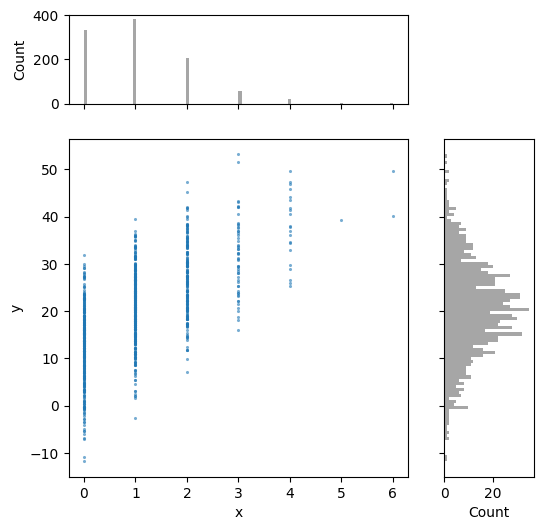

In [8]:
plot_histogram(sim_df)

### Calling optimizer

In [9]:
lam_x = sim_df.x.mean()

In [10]:
mu_y, sigma_y = sim_df.y.mean(), sim_df.y.std()

In [11]:
lam_x, mu_y, sigma_y

(np.float64(1.061),
 np.float64(20.316612218965677),
 np.float64(10.152452018005404))

In [12]:
x_train = np.linspace(-0.99, 0.99, 1000)

In [13]:
copula_params = standalone_copula.CopulaParams()
opt_params = standalone_copula.OptParams()

In [14]:
compula_params = copula_params._replace(lam_x=lam_x, mu_y = mu_y, sigma_y = sigma_y)

In [19]:
num_runs = 20

In [21]:
restart_results = []
for _ in tqdm.tqdm(range(num_runs)):
    loglikvec = standalone_copula.only_log_pois_norm_lik(
        lam_x, 
        mu_y,
        sigma_y,
        sim_df.x,
        sim_df.y,
        copula_params,
        x_train
    )
    peaks, _ = find_peaks(-loglikvec)
    max_peak = x_train[peaks[0]]
    restart_results += [max_peak]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.30it/s]


In [16]:
np.corrcoef(sim_df.x,sim_df.y)[0,1]

np.float64(0.6443432508986957)

In [17]:
peaks, _ = find_peaks(-loglikvec)
max_peak = x_train[peaks[0]]

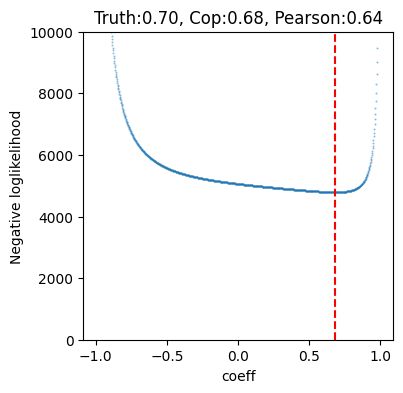

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(
    x_train,
    loglikvec,
    s=2,
    lw=0,
    alpha=0.5
);
plt.axvline(x=max_peak,c='r',ls='--');
plt.ylim(0,10000)
emp_p = np.corrcoef(sim_df.x,sim_df.y)[0,1]
plt.ylabel('Negative loglikelihood')
plt.xlabel("coeff")
plt.title(f"Truth:{coeff:.2f}, Cop:{max_peak:.2f}, Pearson:{emp_p:.2f}");

## Hongyue's data

In [4]:
xen_data = sc.read_h5ad("/n/fs/ragr-data/users/hz7140/external/0111-copulacci/xenium.h5ad")
cod_data = sc.read_h5ad("/n/fs/ragr-data/users/hz7140/external/0111-copulacci/codex.h5ad")

/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/torch-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
xen_array = xen_data.to_df().sum(1).values
cod_array = cod_data.to_df().sum(1).values

In [6]:
xen_genes = xen_data.to_df().columns
cod_genes = cod_data.to_df().columns

In [7]:
xen_counts = xen_data.to_df().values
cod_counts = cod_data.to_df().values

In [8]:
xen_gene_count = xen_counts.shape[1]
cod_gene_count = cod_counts.shape[1]
gene_pairs = [(i, j) for i in range(xen_gene_count) for j in range(cod_gene_count)]

In [38]:
xen_counts.shape, cod_counts.shape

((204650, 476), (204650, 25))

In [57]:
data_pairs = [(xen_counts[:, i], cod_counts[:, j], xen_array, cod_array) for i in range(xen_gene_count) for j in range(cod_gene_count)]

In [10]:
x = data_pairs[0][0]
y = data_pairs[0][1]
xen_array = data_pairs[0][2]
cod_array = data_pairs[0][3]

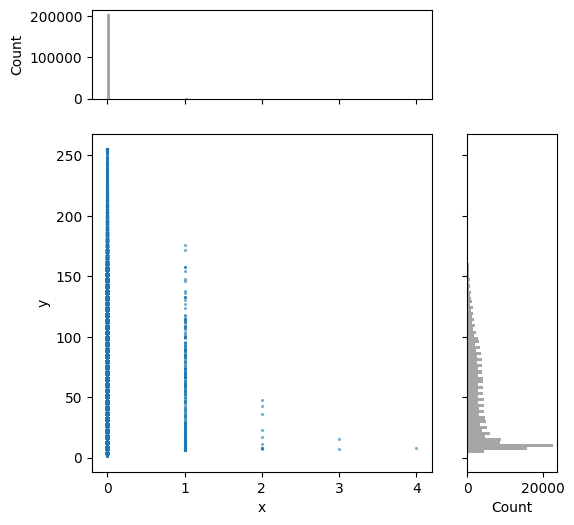

In [11]:
plot_histogram_xy(x, y)

In [28]:
# point estiates
lam_x = x.mean()
mu_y, sigma_y = y.mean(), y.std()

# get loglikelihood
x_train = np.linspace(-0.99, 0.99, 1000)
copula_params = standalone_copula.CopulaParams()
opt_params = standalone_copula.OptParams()
compula_params = copula_params._replace(lam_x=lam_x, mu_y = mu_y, sigma_y = sigma_y, DT=True)
loglikvec = standalone_copula.only_log_pois_norm_lik(
    lam_x, 
    mu_y,
    sigma_y,
    x,
    y,
    copula_params,
    x_train
)

In [12]:
import copula_pois_norm as cpn

In [86]:
importlib.reload(cpn)

<module 'copula_pois_norm' from '/n/fs/ragr-data/users/hirak/Workspace/hongyu_analysis/copula_pois_norm.py'>

In [75]:
x_train = np.linspace(-0.99, 0.99, 1000)

In [79]:
copula_params = cpn.CopulaParams()

In [89]:
def quick_optimize(x,y,x_array,y_array,DT=False,glm_flag=False):
    mu_x = None
    lam_x = None
    if glm_flag:
        mu_x = np.log(x.sum() / x_array.sum())
    else:
        lam_x = x.mean()
    mu_y, sigma_y = y.mean(), y.std()
    
    #print(lam_x)
    copula_params = copula_params._replace(mu_x=mu_x, lam_x=lam_x, mu_y = mu_y, sigma_y = sigma_y, DT=DT)
    #print(copula_params)
    opt_val, status = cpn.quick_find(
        x,
        y,
        copula_params,
        x_train,
        skip_local_min=True
    )
    return [opt_val, status]

In [77]:
cpn.get_dt_cdf(x,x.mean(),False)

array([-0.00180518, -0.00180518, -0.00180518, ..., -0.00180518,
       -0.00180518, -0.00180518])

In [29]:
importlib.reload(cpn)

<module 'copula_pois_norm' from '/n/fs/ragr-data/users/hirak/Workspace/hongyu_analysis/copula_pois_norm.py'>

In [96]:
cpn.quick_find(x,y)

(np.float64(-0.006936936936936866), True, np.float64(-0.0014415955427807552))

In [18]:
opt_res_quick = Parallel(n_jobs=20, verbose=1)(
    delayed(cpn.quick_find)(
        x,
        y,
        skip_local_min=True
    ) for (x, y, _, _) in data_pairs)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   31.5s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  2.5min finished


In [51]:
len(data_pairs)

2500

In [58]:
opt_res_quick_vec = Parallel(n_jobs=20, verbose=1)(
    delayed(cpn.quick_find_vectorized)(
        x,
        y,
        skip_local_min=True
    ) for (x, y, _, _) in data_pairs)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    3.2s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 1480 tasks      | elapsed:   16.2s
[Parallel(n_jobs=20)]: Done 2380 tasks      | elapsed:   26.1s
[Parallel(n_jobs=20)]: Done 3480 tasks      | elapsed:   38.7s
[Parallel(n_jobs=20)]: Done 4780 tasks      | elapsed:   53.3s
[Parallel(n_jobs=20)]: Done 6280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 7980 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 9880 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done 11900 out of 11900 | elapsed:  2.2min finished


In [103]:
cpn.quick_find(x,y,skip_local_min=True)

(np.float64(0.044594594594594694), True, np.float64(0.00549873768123375))

In [59]:
opt_res_df = pd.DataFrame(opt_res_quick, columns=['cop_coeff', 'cop_status', 'ps'])
opt_res_vec_df = pd.DataFrame(opt_res_quick_vec, columns=['cop_coeff', 'cop_status', 'ps'])

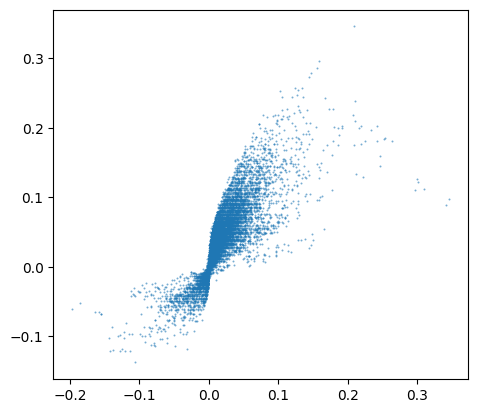

In [63]:
plt.scatter(opt_res_vec_df.ps, opt_res_vec_df.cop_coeff,s=2,lw=0,alpha=0.6);
# plt.plot([-0.9, 0.9], [-0.9, 0.9], color='red', linestyle='--', linewidth=1, label='x = y')
# plt.xlim(-0.9, 0.9)
# plt.ylim(-0.9, 0.9)
plt.gca().set_aspect('equal')

In [64]:
fg = [g1 for (g1,g2) in gene_pairs]
sg = [g2 for (g1,g2) in gene_pairs]

In [66]:
opt_res_vec_df['fg_ind'] = fg
opt_res_vec_df['sg_ind'] = sg

In [67]:
gene_pair_names = pd.DataFrame(
    [(xen_gene, cod_gene) for xen_gene in xen_genes for cod_gene in cod_genes],
    columns=["xen_gene", "cod_gene"]
)

In [69]:
opt_res_vec_df["xen_gene"] = gene_pair_names["xen_gene"]
opt_res_vec_df["cod_gene"] = gene_pair_names["cod_gene"]

In [70]:
opt_res_vec_df.to_csv('norm_pois_0111_copulacci.csv')

In [71]:
xen_data = sc.read_h5ad("/n/fs/ragr-data/users/hz7140/external/0111-copulacci/xenium_base.h5ad")
cod_data = sc.read_h5ad("/n/fs/ragr-data/users/hz7140/external/0111-copulacci/codex_base.h5ad")

/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/torch-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [72]:
xen_array = xen_data.to_df().sum(1).values
cod_array = cod_data.to_df().sum(1).values
xen_counts = xen_data.to_df().values
cod_counts = cod_data.to_df().values

xen_gene_count = xen_counts.shape[1]
cod_gene_count = cod_counts.shape[1]
data_pairs = [(xen_counts[:, i], cod_counts[:, j], xen_array, cod_array) for i in range(xen_gene_count) for j in range(cod_gene_count)]

In [73]:
opt_res_quick_vec = Parallel(n_jobs=20, verbose=1)(
    delayed(cpn.quick_find_vectorized)(
        x,
        y,
        skip_local_min=True
    ) for (x, y, _, _) in data_pairs)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   19.5s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   26.4s
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:   34.3s
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:   43.3s
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:   54.2s
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 8410 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done 9760 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 11210 tasks      

In [74]:
opt_res_vec_df = pd.DataFrame(opt_res_quick_vec, columns=['cop_coeff', 'cop_status', 'ps'])

In [75]:
gene_pair_names = pd.DataFrame(
    [(xen_gene, cod_gene) for xen_gene in xen_genes for cod_gene in cod_genes],
    columns=["xen_gene", "cod_gene"]
)

In [76]:
opt_res_vec_df["xen_gene"] = gene_pair_names["xen_gene"]
opt_res_vec_df["cod_gene"] = gene_pair_names["cod_gene"]

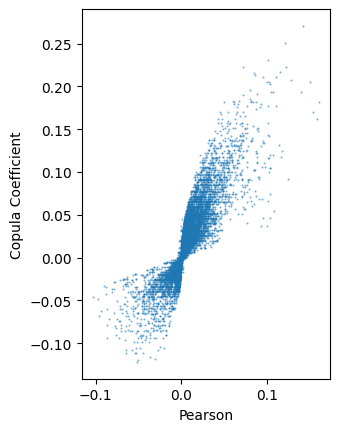

In [80]:
plt.scatter(opt_res_vec_df.ps, opt_res_vec_df.cop_coeff,s=2,lw=0,alpha=0.6);
# plt.plot([-0.9, 0.9], [-0.9, 0.9], color='red', linestyle='--', linewidth=1, label='x = y')
# plt.xlim(-0.9, 0.9)
# plt.ylim(-0.9, 0.9)
plt.gca().set_aspect('equal')
plt.xlabel('Pearson')
plt.ylabel('Copula Coefficient');

In [81]:
opt_res_vec_df.to_csv('norm_pois_0111_base_copulacci.csv')

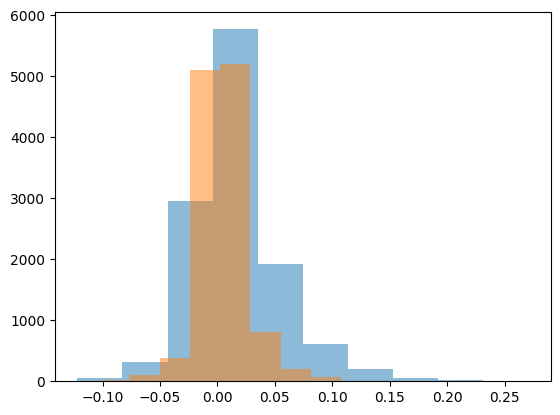

In [84]:
plt.hist(opt_res_vec_df.cop_coeff,alpha=0.5);
plt.hist(opt_res_vec_df.ps,alpha=0.5);

In [87]:
rho_cop_matrix = opt_res_vec_df.pivot(index='xen_gene', columns='cod_gene', values='cop_coeff')

<Axes: xlabel='cod_gene', ylabel='xen_gene'>

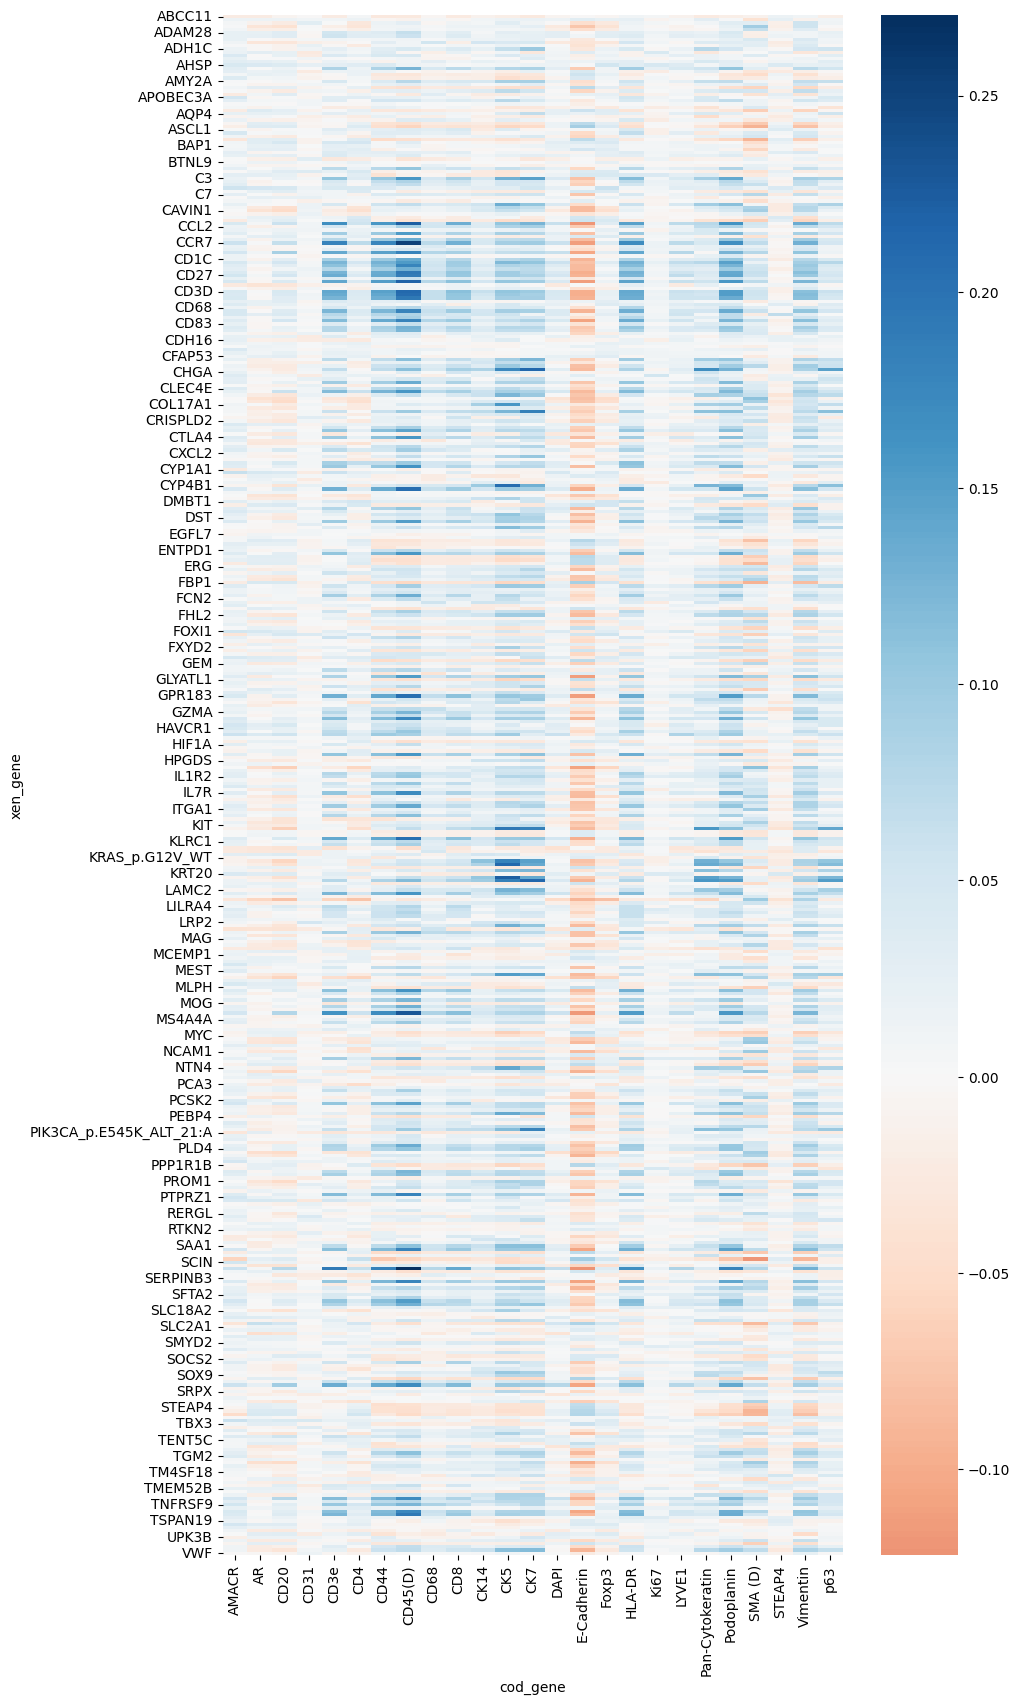

In [92]:
import seaborn as sns
plt.figure(figsize=(10,20))
sns.heatmap(rho_cop_matrix, cmap='RdBu', center=0)

In [95]:
opt_df = pd.read_csv('norm_pois_0111_copulacci.csv', index_col=0)

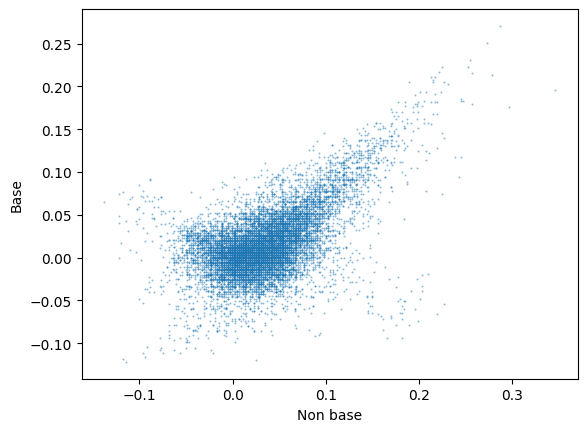

In [101]:
plt.scatter(
    x = opt_df.cop_coeff,
    y = opt_res_vec_df.cop_coeff,
    s = 2,
    lw = 0,
    alpha = 0.5
);
plt.xlabel('Not base')
plt.ylabel('Base');

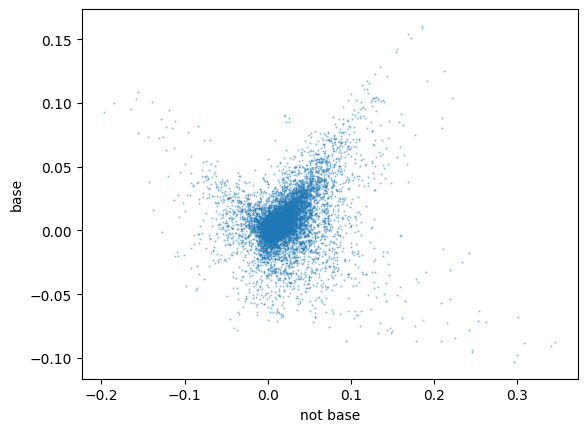

In [103]:
plt.scatter(
    x = opt_df.ps,
    y = opt_res_vec_df.ps,
    s = 2,
    lw = 0,
    alpha = 0.5
);
plt.xlabel('not base')
plt.ylabel('base');

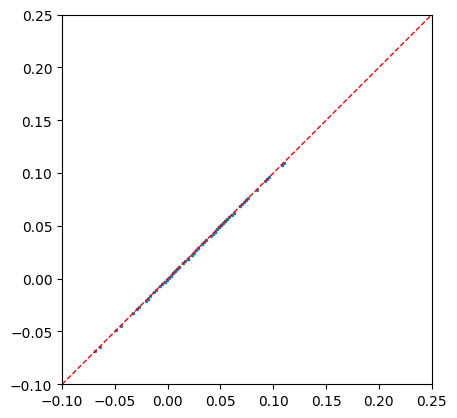

In [48]:
plt.scatter(opt_res_df.cop_coeff, opt_res_vec_df.cop_coeff,s=2);
plt.plot([-0.1, 0.25], [-0.1, 0.25], color='red', linestyle='--', linewidth=1, label='x = y')
plt.xlim(-0.1,0.25)
plt.ylim(-0.1,0.25)
plt.gca().set_aspect('equal')

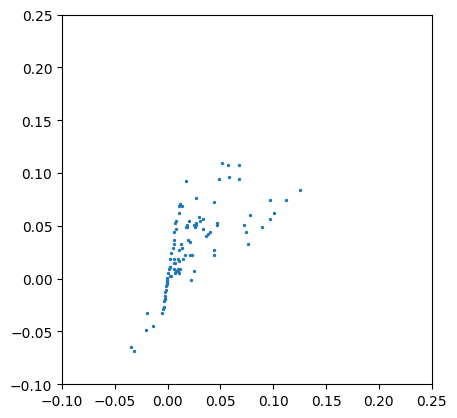

In [28]:
plt.scatter(opt_res_df.ps, opt_res_df.cop_coeff,s=2);
plt.xlim(-0.1,0.25)
plt.ylim(-0.1,0.25)
plt.gca().set_aspect('equal')

In [26]:
opt_res_df

,cop_coeff,cop_status,ps
0,-0.020811,True,-0.003483
1,0.004955,True,0.000382
2,-0.006937,True,-0.001442
3,-0.002973,True,-0.000680
4,0.044595,True,0.005499
...,...,...,...
95,0.026757,True,0.011092
96,0.054505,True,0.030979
97,0.054505,True,0.019806
98,-0.048559,True,-0.020769


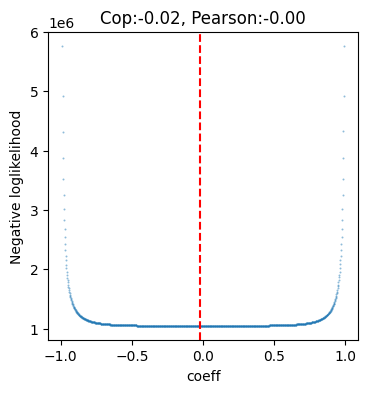

In [31]:
peaks, _ = find_peaks(-loglikvec)
max_peak = x_train[peaks[0]]
plt.figure(figsize=(4,4))
plt.scatter(
    x_train,
    loglikvec,
    s=2,
    lw=0,
    alpha=0.5
);
plt.axvline(x=max_peak,c='r',ls='--');
#plt.ylim(0,10000)
emp_p = np.corrcoef(x,y)[0,1]
plt.ylabel('Negative loglikelihood')
plt.xlabel("coeff")
plt.title(f"Cop:{max_peak:.2f}, Pearson:{emp_p:.2f}");